LOADING AND CLEANING THE DATA
DATASET FROM KAGGLE https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

recipes_df = pd.read_csv('RAW_recipes.csv')

print(recipes_df.head())

                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition  n_steps  \
0       [

In [16]:
print("\nSummary Statistics:")
print(recipes_df.describe())


Summary Statistics:
                  id       minutes  contributor_id        n_steps  \
count  231637.000000  2.316370e+05    2.316370e+05  231637.000000   
mean   222014.708984  9.398546e+03    5.534885e+06       9.765499   
std    141206.635626  4.461963e+06    9.979141e+07       5.995128   
min        38.000000  0.000000e+00    2.700000e+01       0.000000   
25%     99944.000000  2.000000e+01    5.690500e+04       6.000000   
50%    207249.000000  4.000000e+01    1.736140e+05       9.000000   
75%    333816.000000  6.500000e+01    3.982750e+05      12.000000   
max    537716.000000  2.147484e+09    2.002290e+09     145.000000   

       n_ingredients  
count  231637.000000  
mean        9.051153  
std         3.734796  
min         1.000000  
25%         6.000000  
50%         9.000000  
75%        11.000000  
max        43.000000  


In [17]:
print("\nMissing values in each column:")
print(recipes_df.isnull().sum())


Missing values in each column:
name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64


In [18]:
recipes_df = recipes_df.drop(columns=['description'])
print(recipes_df.head())

                                         name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition  n_steps  \
0       [

<ipython-input-19-6660192d7a90>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ingredients), palette='viridis')


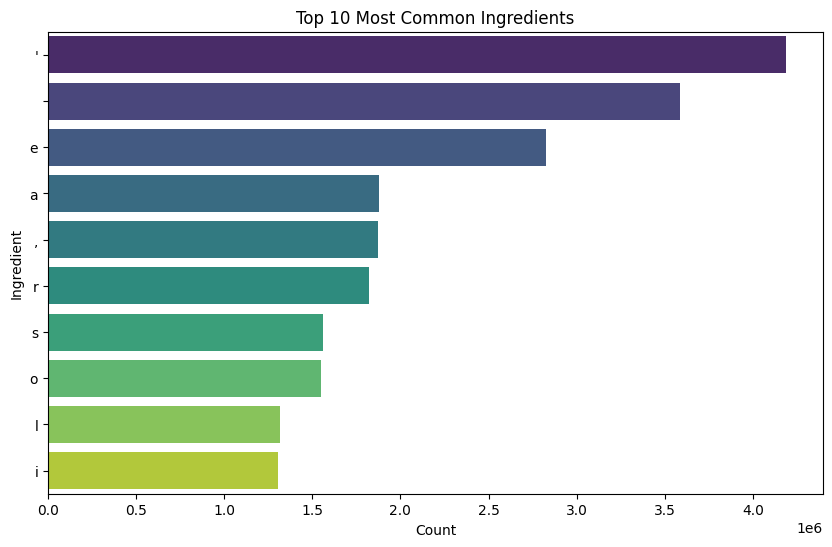

In [19]:
from collections import Counter

all_ingredients = [ingredient for sublist in recipes_df['ingredients'] for ingredient in sublist]

ingredient_counts = Counter(all_ingredients)

top_ingredients = ingredient_counts.most_common(10)

ingredients, counts = zip(*top_ingredients)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(ingredients), palette='viridis')
plt.title('Top 10 Most Common Ingredients')
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.show()

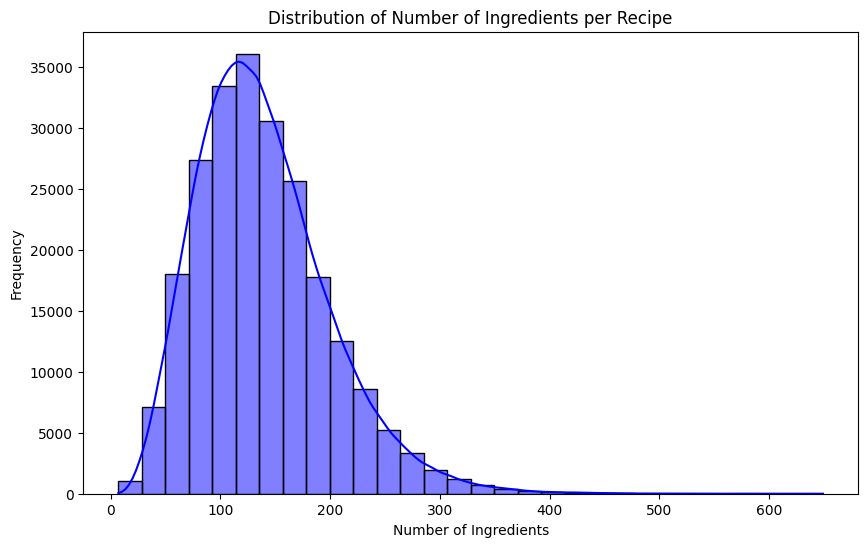

In [20]:
recipe_lengths = recipes_df['ingredients'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(recipe_lengths, bins=30, kde=True, color='blue')
plt.title('Distribution of Number of Ingredients per Recipe')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

In [21]:
scaler = MinMaxScaler()
recipes_df = recipes_df.drop(columns=['id', 'contributor_id', 'tags', 'nutrition', 'steps'])
numerical_columns = ['minutes', 'n_steps', 'n_ingredients']
recipes_df[numerical_columns] = scaler.fit_transform(recipes_df[numerical_columns])

FEATURE ENGINEERING AND DIMENSIONALITY REDUCTION PROCESS

In [ ]:
recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))
recipes_df['ingredients_text'] = recipes_df['ingredients'].apply(lambda x: " ".join(x))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(recipes_df['ingredients_text'])

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

svd = TruncatedSVD(n_components=100)

svd_matrix = svd.fit_transform(tfidf_matrix)

svd_df = pd.DataFrame(svd_matrix, columns=[f"Component_{i+1}" for i in range(svd_matrix.shape[1])])

print(svd_df.head())

TF-IDF Matrix Shape: (231637, 4227)
   Component_1  Component_2  Component_3  Component_4  Component_5  \
0     0.128629    -0.021811    -0.023983     0.000007    -0.051032   
1     0.155753    -0.000028     0.144880    -0.003711    -0.062139   
2     0.275897    -0.134806     0.100444    -0.200323     0.114661   
3     0.278315    -0.211814    -0.005922    -0.051548    -0.097288   
4     0.318744    -0.043162    -0.206327     0.034800     0.074363   

   Component_6  Component_7  Component_8  Component_9  Component_10  ...  \
0     0.045598    -0.052131     0.015260    -0.008631     -0.011705  ...   
1    -0.021567    -0.039412     0.059596    -0.030520      0.065792  ...   
2    -0.255612     0.153038    -0.048803     0.006755      0.038859  ...   
3     0.028345    -0.172969     0.001904     0.069885      0.164194  ...   
4    -0.035362    -0.115163     0.144452    -0.080441      0.042743  ...   

   Component_91  Component_92  Component_93  Component_94  Component_95  \
0      0.06

In [ ]:
def precision_at_k(input_ingredients, recommended_recipe_indices, recipes_df, k=5, threshold=0.5):
    relevant_count = 0

    for idx in recommended_recipe_indices[:k]:
        recipe_ingredients = recipes_df.iloc[idx]['ingredients']

        common_ingredients = set(input_ingredients).intersection(set(recipe_ingredients))

        match_fraction = len(common_ingredients) / len(recipe_ingredients)

        if match_fraction >= threshold:
            relevant_count += 1

    precision = relevant_count / k
    return precision

def measure_diversity(recommended_recipe_indices, recipes_df, top_n=5):
    all_ingredients = []
    for idx in recommended_recipe_indices[:top_n]:
        recipe_ingredients = recipes_df.iloc[idx]['ingredients']
        all_ingredients.extend(recipe_ingredients)

    unique_ingredients = len(set(all_ingredients))
    return unique_ingredients / len(all_ingredients)  # diversity ratio

def cosine_recommend_recipes(input_ingredients, tfidf_vectorizer, svd_matrix, top_n=5):
    input_text = " ".join(input_ingredients)
    input_vector = tfidf_vectorizer.transform([input_text])
    input_vector_svd = svd.transform(input_vector)
    cosine_similarities = cosine_similarity(input_vector_svd, svd_matrix).flatten()

    similar_indices = cosine_similarities.argsort()[-top_n:][::-1]

    print("Input Ingredients:", input_ingredients)
    print("\nTop 5 Recommended Recipes:")
    for i, idx in enumerate(similar_indices):
        recipe_name = recipes_df.iloc[idx]['name']
        recipe_ingredients = recipes_df.iloc[idx]['ingredients']
        similarity_score = cosine_similarities[idx]
        print(f"{i+1}. {recipe_name} (Similarity Score: {similarity_score:.4f})")
        print(f"   Ingredients: {recipe_ingredients}")
        print()

    return similar_indices, cosine_similarities[similar_indices]

def knn_recommend_recipes(input_ingredients, tfidf_vectorizer, tfidf_matrix, n_neighbors=5):
    input_text = " ".join(input_ingredients)
    input_vector = tfidf_vectorizer.transform([input_text])

    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(tfidf_matrix)

    distances, indices = knn.kneighbors(input_vector)

    print("Input Ingredients:", input_ingredients)
    print("\nTop 5 Recommended Recipes (KNN):")
    for i, (idx, distance) in enumerate(zip(indices.flatten(), distances.flatten())):
        recipe_name = recipes_df.iloc[idx]['name']
        recipe_ingredients = recipes_df.iloc[idx]['ingredients']
        print(f"{i+1}. {recipe_name} (Cosine Similarity Score: {1 - distance:.4f})")
        print(f"   Ingredients: {recipe_ingredients}")
        print()

    return indices.flatten(), distances.flatten()

def nmf_recommend_recipes(input_ingredients, tfidf_vectorizer, tfidf_matrix, n_components=5, top_n=5):
    input_text = " ".join(input_ingredients)
    input_vector = tfidf_vectorizer.transform([input_text])

    nmf = NMF(n_components=n_components, random_state=42)
    nmf_matrix = nmf.fit_transform(tfidf_matrix)

    input_vector_nmf = nmf.transform(input_vector)
    cosine_similarities = cosine_similarity(input_vector_nmf, nmf_matrix).flatten()

    similar_indices = cosine_similarities.argsort()[-top_n:][::-1]

    print("Input Ingredients:", input_ingredients)
    print("\nTop 5 Recommended Recipes (NMF):")
    for i, idx in enumerate(similar_indices):
        recipe_name = recipes_df.iloc[idx]['name']
        recipe_ingredients = recipes_df.iloc[idx]['ingredients']
        similarity_score = cosine_similarities[idx]
        print(f"{i+1}. {recipe_name} (Similarity Score: {similarity_score:.4f})")
        print(f"   Ingredients: {recipe_ingredients}")
        print()

    return similar_indices, cosine_similarities[similar_indices]

input_ingredients = ['eggs', 'bread', 'butter', 'salt', 'bacon', 'pepper']


In [ ]:
start_time = time.time()
recommended_indices_svd, similarity_scores_svd = cosine_recommend_recipes(input_ingredients, tfidf_vectorizer, svd_matrix, top_n=5)
svd_time = time.time() - start_time
precision_svd = precision_at_k(input_ingredients, recommended_indices_svd, recipes_df, k=5, threshold=0.5)
diversity_svd = measure_diversity(recommended_indices_svd, recipes_df, top_n=5)

print("Results for Cosine-based Recommendation:")
print(f"Precision at K (P@5): {precision_svd:.4f}")
print(f"Time taken: {svd_time:.4f} seconds")
print(f"Diversity: {diversity_svd:.4f}\n")

Input Ingredients: ['eggs', 'bread', 'butter', 'salt', 'bacon', 'pepper']

Top 5 Recommended Recipes:
1. eggs lookin  at you (Similarity Score: 1.0000)
   Ingredients: ['butter', 'bread', 'bacon', 'eggs', 'salt & pepper']

2. the greasemeister (Similarity Score: 0.9619)
   Ingredients: ['eggs', 'bread', 'meat', 'cheese', 'bacon', 'butter', 'salt', 'pepper', 'grey poupon']

3. bacon and egg sandwich (Similarity Score: 0.9332)
   Ingredients: ['bacon', 'eggs', 'bread', 'cheese', 'butter', 'strawberries', 'ketchup', 'salt', 'pepper']

4. homemade egg macmuffins (Similarity Score: 0.8722)
   Ingredients: ['white bread', 'eggs', 'butter', 'crisp bacon']

5. eggs in muffin cups (Similarity Score: 0.8710)
   Ingredients: ['eggs', 'white bread', 'bacon', 'butter']

Results for Cosine-based Recommendation:
Precision at K (P@5): 1.0000
Time taken: 0.2676 seconds
Diversity: 0.4516



In [ ]:
start_time = time.time()
recommended_indices_knn, distances_knn = knn_recommend_recipes(input_ingredients, tfidf_vectorizer, tfidf_matrix, n_neighbors=5)
knn_time = time.time() - start_time
precision_knn = precision_at_k(input_ingredients, recommended_indices_knn, recipes_df, k=5, threshold=0.5)
diversity_knn = measure_diversity(recommended_indices_knn, recipes_df, top_n=5)

print("Results for KNN-based Recommendation:")
print(f"Precision at K (P@5): {precision_knn:.4f}")
print(f"Time taken: {knn_time:.4f} seconds")
print(f"Diversity: {diversity_knn:.4f}\n")

Input Ingredients: ['eggs', 'bread', 'butter', 'salt', 'bacon', 'pepper']

Top 5 Recommended Recipes (KNN):
1. eggs lookin  at you (Cosine Similarity Score: 1.0000)
   Ingredients: ['butter', 'bread', 'bacon', 'eggs', 'salt & pepper']

2. eggs in muffin cups (Cosine Similarity Score: 0.8560)
   Ingredients: ['eggs', 'white bread', 'bacon', 'butter']

3. eggs baked in bacon ring (Cosine Similarity Score: 0.8299)
   Ingredients: ['bacon', 'eggs', 'salt & pepper', 'butter']

4. gypsy bacon (Cosine Similarity Score: 0.7994)
   Ingredients: ['bacon', 'bread']

5. bacon  eggs  and toast  my version (Cosine Similarity Score: 0.7921)
   Ingredients: ['eggs', 'bacon', 'bread', 'margarine', 'salt', 'pepper']

Results for KNN-based Recommendation:
Precision at K (P@5): 1.0000
Time taken: 0.2729 seconds
Diversity: 0.4286



In [ ]:
start_time = time.time()
recommended_indices_nmf, distances_nmf = nmf_recommend_recipes(input_ingredients, tfidf_vectorizer, tfidf_matrix, n_components=5, top_n=5)
nmf_time = time.time() - start_time
precision_nmf = precision_at_k(input_ingredients, recommended_indices_nmf, recipes_df, k=5, threshold=0.5)
diversity_nmf = measure_diversity(recommended_indices_nmf, recipes_df, top_n=5)

print("Results for NMF-based Recommendation:")
print(f"Precision at K (P@5): {precision_nmf:.4f}")
print(f"Time taken: {nmf_time:.4f} seconds")
print(f"Diversity: {diversity_nmf:.4f}\n")

Input Ingredients: ['eggs', 'bread', 'butter', 'salt', 'bacon', 'pepper']

Top 5 Recommended Recipes (NMF):
1. eggs lookin  at you (Similarity Score: 1.0000)
   Ingredients: ['butter', 'bread', 'bacon', 'eggs', 'salt & pepper']

2. eggs baked with tomatoes (Similarity Score: 1.0000)
   Ingredients: ['whole tomatoes', 'all-purpose flour', 'green pepper', 'dried chervil', 'eggs', 'salt', 'parmesan cheese', 'toast']

3. vegetable cheese souffle (Similarity Score: 0.9999)
   Ingredients: ['butter', 'flour', 'salt', 'cayenne pepper', 'milk', 'sharp cheddar cheese', 'egg yolks', 'sliced mushrooms', 'red bell peppers', 'broccoli', 'olive oil', 'egg whites', '"confectioners sugar"']

4. pepperoni pizza bread for the bread machine (Similarity Score: 0.9999)
   Ingredients: ['water', 'bread flour', 'mozzarella cheese', 'sugar', 'garlic salt', 'dried oregano', 'yeast', 'pepperoni']

5. fabulous oregano bread  or pizza dough (Similarity Score: 0.9997)
   Ingredients: ['water', 'olive oil', 'salt',

In [ ]:
comparison_table = pd.DataFrame({
    "Model": ["Cosine + SVD", "KNN", "NMF"],
    "Precision at K (P@5)": [precision_svd, precision_knn, precision_nmf],
    "Time Taken (sec)": [svd_time, knn_time, nmf_time],
    "Diversity": [diversity_svd, diversity_knn, diversity_nmf]
})

print("Comparison Table:")
print(comparison_table)

Comparison Table:
          Model  Precision at K (P@5)  Time Taken (sec)  Diversity
0  Cosine + SVD                   1.0          0.267627         14
1           KNN                   1.0          0.272932          9
2           NMF                   0.2         10.183749         33
